# Can ResNet count?
The training data consists of pictures with 100 by 100 pixels, containing either one or two blobs, where the blobs are solid, non-overlapping, axis-aligned ellipses of various sizes.

Then we let ResNet-18 loose on the data, with all the same settings as the last section in https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb

Spoiler: the answer is yes it can, which is impressive given there are only 100 training pictures.

In [49]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [50]:
from fastai.vision.all import *
from fastbook import *

In [51]:
from PIL import Image, ImageDraw

## Constants

Even with only 100 training pictures, ResNet converges on 100% success.

In [52]:
pictureSize = 100
minDiameter = 10
maxDiameter = 40
margin = 3
minSeparation = 2
numCirclesCategories = [1,2]   # i.e. some pictures have 1 circle and some have 2 circles.
loaders = [('train', 50), ('valid', 50)]  # names and num samples (per numCircles category)
overlapThreshold = 5

## Functions for generating the random PNGs and saving them to disk

In [53]:
# Create the PNG files and the label.csv file.
def createBlobs():
    with open('labels.csv', 'w') as labels_fh:
        labels_fh.write('name,label\n')
        for loaderName, loaderSize in loaders:
            if os.path.exists(loaderName):
                shutil.rmtree(loaderName)
            for numCircles in numCirclesCategories:
                os.makedirs(f'{loaderName}/{numCircles}')
                for i in range(loaderSize):
                    labels_fh.write(f'{loaderName}/{numCircles}/{i}.png,{numCircles}\n')
                    createPNG(loaderName, numCircles, i)

In [54]:
# Create a PNG file.
def createPNG(loaderName, numCircles, i):
    img = Image.new('RGB', (pictureSize, pictureSize), color = 'white')
    d = ImageDraw.Draw(img)
    circles = chooseCircles(numCircles)
    for left, top, xDiam, yDiam in circles:
        d.ellipse([left, top, left + xDiam, top + yDiam],
                  fill=(random.randint(0, 200), random.randint(0, 200), random.randint(0, 200)))
    img.save(f'{loaderName}/{numCircles}/{i}.png')

In [55]:
# Return a list of non-overlapping ellipses.  Each ellipse is represented
# as a tuple of four integers.
def chooseCircles(numCircles):
    while True:
        circles = tryToChooseCircles(numCircles)
        if circles:
            return circles

In [56]:
# Return a list of non-overlapping ellipses, or None if any of them overlap.
def tryToChooseCircles(numCircles):
    circles = []
    for i in range(numCircles):
        xDiam = random.randint(minDiameter, maxDiameter)
        yDiam = random.randint(minDiameter, maxDiameter)
        left = random.randint(margin, pictureSize - margin - xDiam)
        top  = random.randint(margin, pictureSize - margin - yDiam)
        circles.append((left, top, xDiam, yDiam))
        for j in range(i):
            if overlapping(circles[-1], circles[j]):
                return None
    return circles

In [57]:
# Return true if the circles enclosing the two ellipses overlap or nearly overlap.
def overlapping(a, b):
    maxDiam_a = max(a[2], a[3])
    maxDiam_b = max(b[2], b[3])
    sumOfRadii = (maxDiam_a + maxDiam_b) / 2
    distBetweenCentres = math.hypot(a[0] - b[0], a[1] - b[1])
    return sumOfRadii + overlapThreshold > distBetweenCentres

## Generate the data

In [58]:
random.seed(42)
createBlobs()

In [59]:
dls = ImageDataLoaders.from_folder('.')

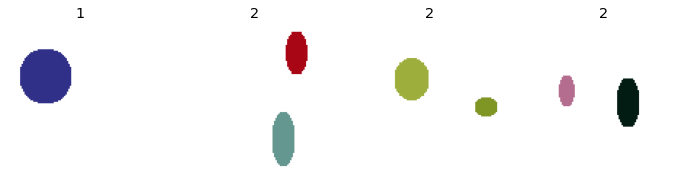

In [60]:
dls.train.show_batch(max_n=4, nrows=1)

## Train the model

Notice how the accuracy doesn't improve at all until the 97th epoch.

In [61]:
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(150, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.542421,889.823486,0.500000,00:00
1,3.306161,17706.449219,0.500000,00:00
2,3.105307,53549.714844,0.500000,00:00
3,2.778136,76879.773438,0.500000,00:00
4,2.349092,99089.859375,0.500000,00:00
5,2.028301,103864.328125,0.500000,00:00
6,1.784481,109240.742188,0.500000,00:00
7,1.597867,111381.187500,0.500000,00:00
8,1.446577,83833.906250,0.500000,00:00
9,1.328766,203.960861,0.500000,00:00
